# Gradient descent methods
#### By Jane Kim (janekim@ohio.edu, Lindley S269)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Introduction

Iterative optimization methods often prove to be the most efficient approach for solving nonlinear optimization problems, with some challenges necessitating their use. The goal of this notebook is to understand the mathematics behind gradient descent methods, the most popular family of iterative optimization methods. It's worth noting that these methods extend far beyond the realm of "machine learning" and are applicable to a broad spectrum of optimization problems. 

On Wednesday, we will be using [Keras](https://keras.io) to build and train artificial neural networks. Keras is a deep learning framework built on top of [TensorFlow](https://www.tensorflow.org). In order to compile our model, we will need two key ingredients: the [loss](https://keras.io/api/losses/) (aka cost) function and the [optimizer](https://keras.io/api/optimizers/). Both the loss and optimizer will be specified as keyword arguments (kwargs) to Keras's [compile](https://keras.io/api/models/model_training_apis/) method.

Instead of experimenting with different kwargs for the optimizer and comparing their performances phenomenologically, you will implement a few different optimizers yourself. It is much easier than it sounds. You'll quickly appreciate the importance of specific modifications and understand when they are necessary. This hands-on experience will empower you with the confidence to tackle any optimization problem you encounter!

## Cost functions and the branches of machine learning

The numerical methods we will discuss in this notebook can be used to minimize or maximize _any_ objective function with respect to _any_ free parameters. Without loss of generality, we will always frame our optimization task as minimization (for maximization, flip the sign). In machine learning, the function we minimize is typically referred to as the cost or loss function. The terms cost and loss function are often used interchangeably, but there is a subtle difference. The loss function is evaluated on a single data point, while the cost function is evaluated over a group of data points.

In class, we will discuss in more detail how the characteristics of the data influence the choice of model and dictate the overall structure of the problem. Here's an brief summary of what we'll cover:

- **Supervised learning.** The data points come in pairs $(\mathbf{x}_i, \mathbf{y}_i)$, where $\mathbf{x}_i$ lives in the input space and $\mathbf{y}_i$ lives in the output (or target) space. If the outputs $\mathbf{y}_i$ are continuous, you have a regression problem. If they are discrete, you have a classification problem. Either way, the goal is to learn a generalizable mapping between the input and output spaces, where examples of the endpoints are given by your data. The cost function will be dependent on the data inputs $\mathbf{x}_i$, data outputs $\mathbf{y}_i$, explicit model outputs $\mathbf{\hat{y}}(\mathbf{x}_i)$, and model parameters $\mathbf{p}$, 
$$C=C(\{\mathbf{x}_i\}, \{\mathbf{y}_i\}, \{\mathbf{\hat{y}}(\mathbf{x}_i)\}; \mathbf{p} ).$$ 
Below, the left figure depicts a regression problem, while the right figure depicts a classification problem. 

<img src="Cartoons/SupervisedLearning.png" alt="SL" width="600" height="150">


- **Unsupervised learning.** All you have is input data $\mathbf{x}_i$. The objective is to uncover underlying patterns within the data or deviations from those patterns, primarily aimed at achieving dimensionality reduction, clustering, or detecting anomalies. The cost function is only dependent on the input data $\mathbf{x}_i$ and the model parameters $\mathbf{p}$,
$$C=C(\{\mathbf{x}_i\}; \mathbf{p} ).$$ 
There are different levels of assumptions you can make about the structure of your data that can help you decide which algorithm is most suitable. In the left figure below, the data has structure similar to a lower-dimensional plane. In the right figure below, the data has structure similar to $n$-spheres.

<img src="Cartoons/UnsupervisedLearning.png" alt="SL" width="600" height="150">

- **Reinforcement learning.** The data depends on the model, and the model depends on the data. This feedback loop characterizes reinforcement learning and is especially useful for tasks where gathering enough training data, as in supervised learning, would be impractical or impossible. Suppose your model is initialized with random parameters $\mathbf{p}^{(0)}$. For any given iteration of the training process $t>0$, the cost function can be written as
$$C_t = C(\{\mathbf{x}^{(t)}_i(\mathbf{p}^{(t-1)})\}).$$
Notice how the data points $\mathbf{x}^{(t)}_i$ are dependent on the previous set of parameters $\mathbf{p}^{(t-1)}$. The cost function is then used to update the parameters $\mathbf{p}^{(t)}$. Fully expanding the cost function is cumbersome, but exposes the feedback loop:
$$C_t = C(\{\mathbf{x}^{(t)}_i(\mathbf{p}^{(t-1)}(\{\mathbf{x}^{(t-1)}_i(\mathbf{p}^{(t-2)}\cdots\{\mathbf{x}^{(1)}_i(\mathbf{p}^{(0)})\} \cdots)\}))\}).$$ In the cartoon below, a physics-motivated example of a reinforcement learning problem (variational Monte Carlo) is illustrated within the context of agent-based modeling, a prevalent framework in reinforcement learning. Here, the agent navigates its environment while continuously gathering data. Subsequently, this acquired data informs updates to the agent, thereby shaping its future interactions with the environment. This process closely mirrors how much of our own learning occurs throughout our daily lives.

<img src="Cartoons/VariationalMonteCarlo.png" alt="SL" width="800" height="300">


The tools and concepts used in the various branches of machine learning are not mutually exclusive. In fact, complex problems often demand a combination of different models working collaboratively to accomplish the intended goal. Understanding the strengths and weaknesses of the different branches helps streamline the development of effective strategies when tackling new and unfamiliar challenges.

**<font color='red'>Note:</font>** In the example we will explore below, there is no need to collect any data to compute our cost function (the mean-field free energy). We will focus solely on tuning the "model parameters" (the average magnetization).

___

## The simplest gradient descent algorithm

Our objective is to minimize the cost function $C(\mathbf{p})$ with respect to the model parameters $\mathbf{p}$. For brevity, we have omitted the dependence on any variables other than $\mathbf{p}$. The basic assumption of all gradient descent methods is that the gradient $\nabla_\mathbf{p}C(\mathbf{p})$ is relatively efficient to compute. The simplest formulation of the gradient descent method is as follows:

1. Initialize the parameters $\mathbf{p}^{(0)}$. Provide your best guess if you have some intuition, otherwise, choose randomly. 
2. For each iteration $t > 0$, update the parameters as $\mathbf{p}^{(t)} = \mathbf{p}^{(t-1)} - \eta \nabla_\mathbf{p}C(\mathbf{p}^{(t-1)})$. The learning rate $\eta$ is a small positive number that controls the size of the change in the parameters, usually chosen between $10^{-5}$ and $10^{-2}$. 
3. Stop updating the parameters after a fixed number of optimization steps, or after changes in the cost function drops below some tolerance level. 
___

## Background: The mean-field solution of the Ising model

As an illustrative example, we will consider the mean-field solution of the [Ising model](https://cpb-us-w2.wpmucdn.com/u.osu.edu/dist/3/67057/files/2018/09/Ising_model_MFT-25b1klj.pdf), a simple yet powerful model for understanding ferromagnetism, phase transitions, and critical behavior. Feel free to skip this background section if you want. For our purposes, we will only need the final equation for the mean-field free energy, which is boxed at the end of this section. The reason I chose this example is because the shape of the free energy highlights some of the pros and cons of the different optimization methods we will explore. 

Here's an outline of the steps required to derive the free energy:

- **Hamiltonian.** Consider a lattice of $N$ spins, with the spin at lattice site $i$ denoted as $s_i = +1$ if it points upwards, and $s_i=-1$ if it points downwards. The Hamiltonian is given by
$$H = - h \sum_{i=1}^N s_i - J \sum_{\langle i j \rangle}^N s_i s_j,$$
where $h$ is the coupling to the external magnetic field, $J$ is the interaction strength, and the notation $\displaystyle{\sum_{\langle i j \rangle}^N}$ means "sum over all nearest-neighbor pairs". For each spin, the number of nearest-neighbors will depend on the geometry of the lattice. To keep things general, we'll say that the number of nearest-neighbors for each spin is some integer $q$ (for example, $q=4$ for a 2D square lattice). 

- **Mean-field approximation.** The idea of mean-field theory is to approximate an interacting system with a non-interacting system. In the context of the Ising model, this means we want to find a new Hamiltonian with the form
$$H_{MF} = - h_{MF} \sum_{i=1}^N s_i + C,$$
such that $H_{MF} \approx H$, where $C$ is some constant that doesn't affect the Boltzmann factors. To find $h_{MF}$, we first write each spin in terms of fluctuations about an average spin value
$$s_i = \langle s_i \rangle + \delta s_i.$$
Since our lattice is translationally invariant, the average value of the spin $\langle s_i \rangle$ should not depend on the location of lattice site $i$. In other words, 
$$\langle s_i \rangle = m \text{ for all } i,$$
where $m$ is called the average magnetization or magnetization density. Now we can rewrite the spin-interaction term of the Hamiltonian as
$$ s_i s_j = (m + \delta s_i ) (m + \delta s_j) = m^2 + m \delta s_i + m \delta s_j + \delta s_i \delta s_j.$$
Now for the crucial step: we *assume fluctuations are small* and ignore the last term! 
$$\delta s_i \delta s_j \approx 0$$
Then with some algebra, we can write down the mean-field Hamiltonian:
$$H_{MF} = - (h + qJm) \sum_{i=1}^N s_i + \frac{N q J m^2}{2}.$$ **<font color='blue'>Exercise:</font>** Show that $h_{MF} = h+qJm$ and $C = \displaystyle{\frac{N q J m^2}{2}} $. 

- **Partition function.** Like the wave function in quantum mechanics, the partition function in statistical mechanics can be used to extract important statistical information from the system. Now that we have the mean-field Hamiltonian, we can simply write down the partition function, and simplify:
$$Z_{MF} = Tr \left[ e^{-\beta H_{MF}} \right] = \cdots = e^{-\beta N q J m^2 /2} \big[ 2 \cosh(\beta (h + qJm)) \big]^N$$ **<font color='blue'>Exercise:</font>** Confirm the form of the mean-field partition function above by taking the trace (i.e. sum over all possible configurations).

- **Free energy.** The free energy is a measure of the energy available to do useful work in a system, taking into account both the internal energy and the energy lost to entropy. 
$$F = E - TS$$
The partition function gives us (almost) immediate access to the free energy through the following relationship:
$$F = -\frac{1}{\beta} \ln Z$$**<font color='blue'>Exercise:</font>** Show that the mean-field free energy is given by
$$\boxed{ \ F_{MF} =  \frac{N q J m^2}{2} - \frac{N \ln 2}{\beta} - \frac{N}{\beta} \ln \big[ \cosh (\beta (h+qJm))\big] \ \ }$$
___


## Example: Minimizing the mean-field free energy

Fix the total number of spins $N = 16$ on a 2D square lattice with $q=4$ and interaction strength $J=1$. The goal is to minimize the mean-field free energy $F_{MF}(m)$ with respect to the average magnetization $m$, for different values of the external magnetic field coupling $h$ and inverse temperature $\beta=1/k_B T$. It is convenient to know that the critical inverse temperature at zero field $h=0$ is $\beta_c = 1/qJ$.

First, let's explore our problem by testing how $\beta$ and $h$ affect the shape of the free energy.

**<font color='blue'>Exercise:</font>** Set the relevant constants and write a function for the cost function below. 

In [3]:
N = 16
q = 4
J = 1
beta_c = 1/(q*J)

def free_energy(m, h=0, beta=beta_c):
    return N*q*J*m**2/2. - N*np.log(2)/beta - N*np.log(np.cosh(beta*(h+q*J*m)))/beta

**<font color='blue'>Exercise:</font>** Plot the cost function over the domain $m \in [-2, 2]$ for $h = 0$ and various values of $\beta$ below, at, and above $\beta_c$. Keep in mind the physically allowed values of the magnetization are $m \in [-1, 1]$. How do the locations of the minima change as you vary $\beta$?

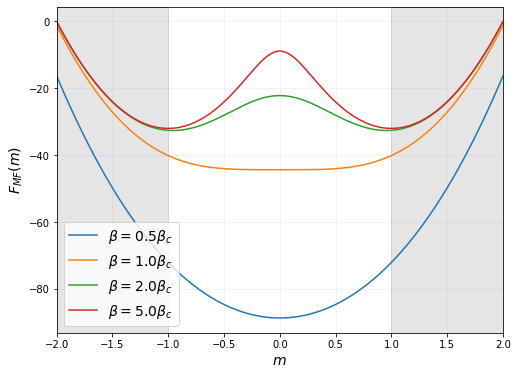

In [4]:
# set figure size
plt.figure(figsize=(8,6))

# plot cost for different values of beta
m = np.linspace(-2, 2, num=1000)
for f in [0.5, 1.0, 2.0, 5.0]:
    plt.plot(m, free_energy(m, beta=f*beta_c), label=r'$\beta=$'+str(f)+r'$\beta_c$')

# shade non-physical values of m in gray
plt.axvspan(-2, -1, color='black', alpha=0.1)
plt.axvspan(1, 2, color='black', alpha=0.1)

# format plot
plt.ylabel(r'$F_{MF}(m)$', fontsize=14)
plt.xlabel(r'$m$', fontsize=14)
plt.xlim(-2, 2)
plt.grid(alpha=0.2)
plt.legend(fontsize=14)
plt.show()

**<font color='blue'>Exercise:</font>** Plot the cost function for $\beta=2\beta_c$ and various values of $h \geq 0$. What happens to the symmetry of the free energy as you increase $h$? Identify global and local minima. 

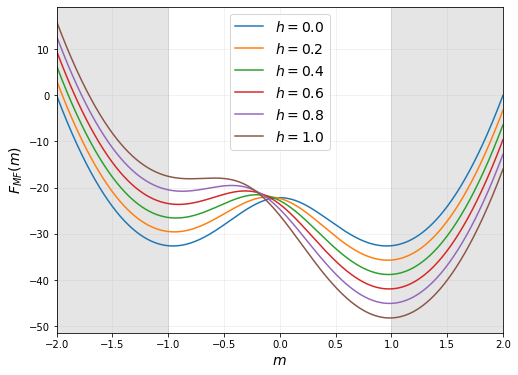

In [7]:
# set figure size
plt.figure(figsize=(8,6))

# plot cost for different values of h
m = np.linspace(-2, 2, num=1000)
for h in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    plt.plot(m, free_energy(m, h=h, beta=2*beta_c), label=r'$h=$'+str(h))

# shade non-physical values of m in gray
plt.axvspan(-2, -1, color='black', alpha=0.1)
plt.axvspan(1, 2, color='black', alpha=0.1)

# format plot
plt.ylabel(r'$F_{MF}(m)$', fontsize=14)
plt.xlabel(r'$m$', fontsize=14)
plt.xlim(-2, 2)
plt.grid(alpha=0.2)
plt.legend(fontsize=14)
plt.show()

As you can see in the plot above, when $\beta > \beta_c$ and $h=0$, there are two minima with exactly the same energy. If $h\gtrsim0$, the symmetry is broken and one minimum becomes the global minimum, while the other becomes a local minimum. Dealing with local minima is one of the central issues for gradient descent methods, as one can get trapped in local minima and training can stall. 

Let's focus on the particular case of $\beta = 2\beta_c$ and $h=1$ to investigate this further. 

In [24]:
beta = 2*beta_c
h = 1.0

**<font color='blue'>Exercise:</font>** Write down the derivative of the cost function with respect to the free parameter.

$$\frac{d}{dm} F_{MF}(m) = NqJ \big( m - \tanh (\beta(h+qJm))\big)$$

**<font color='blue'>Exercise:</font>** Write a function that computes the derivative of the cost. I have also included a scaled Gaussian noise term for later.

In [25]:
def gradient(m, noise=0.0):
    return N*q*J*(m - np.tanh(beta*(h+q*J*m))) + np.random.normal(scale=N*q*J*noise)

**<font color='blue'>Exercise:</font>** Write a function that uses the gradient descent algorithm to minimize the cost function for the chosen case $\beta=2\beta_c$ and $h=1$. A skeleton of the code is provided below to help you get started.

In [42]:
def gradient_descent(p0=0.0, eta=0.001, nopt=1000):
    
    # initialize arrays for free parameter and gradient of cost
    p = np.zeros(nopt) 
    g = np.zeros(nopt)
    
    # set the initial free parameter and gradient
    p[0] = p0
    g[0] = gradient(p0)
    
    for t in range(1, nopt):
        
        # update the parameter
        p[t] = p[t-1] - eta * g[t-1]
        
        # compute the gradient at new parameter
        g[t] = gradient(p[t])
        
    return p

The function below takes an optimizer function as input, plots the training of $m$ for various initial values, and prints a table of the magnetization before and after training.

In [43]:
def plot_training(optimizer, navg=20, **kwargs):
    
    # heading
    print(f"{'Initial':>10s} {'Final':>20s}")
    
    # set figure size
    plt.figure(figsize=(8,6))

    # call optimizer with various initial parameters
    for m0 in np.linspace(-2, 2, num=15):

        m = optimizer(p0=m0, **kwargs)
        plt.plot(m)
        
        mf = np.mean(m[-navg:])
        print(f"{m0:10.5f} {mf:20.5f}")
        
    # format plot
    plt.ylabel(r'$m$', fontsize=14)
    plt.xlabel(r'Optimization step', fontsize=14)
    plt.grid(alpha=0.2)
    plt.show()

**<font color='blue'>Exercise:</font>** Plot how the average magnetization evolves during the training process for various initial values of $m$. Do all the paths converge to the same solution? Why do some paths converge faster than others?

   Initial                Final
  -2.00000             -0.80176
  -1.71429             -0.80176
  -1.42857             -0.80176
  -1.14286             -0.80176
  -0.85714             -0.80176
  -0.57143              0.98584
  -0.28571              0.98584
   0.00000              0.98584
   0.28571              0.98584
   0.57143              0.98584
   0.85714              0.98584
   1.14286              0.98584
   1.42857              0.98584
   1.71429              0.98584
   2.00000              0.98584


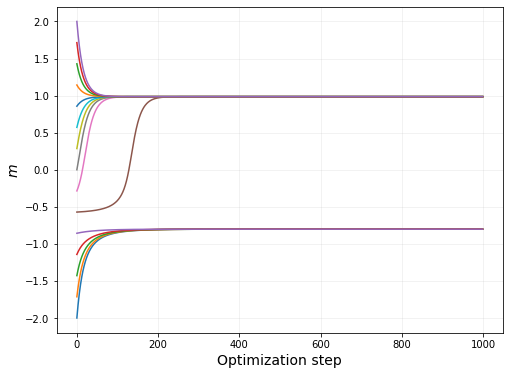

In [45]:
plot_training(gradient_descent, nopt=1000)

## Stochastic gradient descent


Since our expression for the gradient is exact, the training curves above should be very smooth. However, you have probably noticed that certain initial values will cause the gradient descent method to fall into the local minimum at $m \approx -1$, rather than the global minimum at $m \approx +1$. 

One primitive strategy for escaping local minima is to introduce noise into our gradient. In real-world machine learning problems, this is often done by computing the gradient over a small subset of the data, or even just a single data point. Our toy problem has no data points to consider, so let's simulate this effect with Gaussian noise (I already placed the noise term into the `gradient` function from earlier and scaled it appropriately).

**<font color='blue'>Exercise:</font>** Write a function that simulates the stochastic gradient descent method by introducing noise into the gradient. 

In [38]:
def sgd(p0=np.random.uniform(-1, 1), eta=0.001, nopt=1000, noise=0.5):
    
    # initialize arrays for free parameter and gradient of cost
    p = np.zeros(nopt) 
    g = np.zeros(nopt)
    
    # set the initial free parameter and gradient
    p[0] = p0
    g[0] = gradient(p0, noise=noise)
    
    for t in range(1, nopt):
        
        # update the parameter
        p[t] = p[t-1] - eta * g[t-1]
        
        # compute the gradient at new parameter
        g[t] = gradient(p[t], noise=noise)
        
    return p

**<font color='blue'>Exercise:</font>** Plot the training curves for the stochastic gradient descent method. How large does the noise need to be in order to spontaneously escape the local minimum?

   Initial                Final
  -2.00000              1.01955
  -1.71429              0.97815
  -1.42857              0.88441
  -1.14286              1.06318
  -0.85714              0.98169
  -0.57143              0.87877
  -0.28571              0.92151
   0.00000              0.99421
   0.28571              1.06865
   0.57143              0.98080
   0.85714              1.07401
   1.14286              1.02236
   1.42857              0.82404
   1.71429              0.96798
   2.00000              0.96618


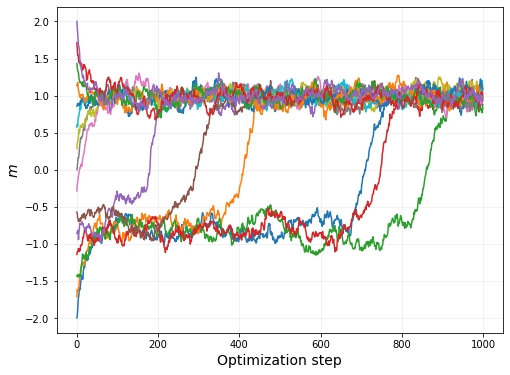

In [39]:
plot_training(sgd, nopt=1000)

## Stochastic gradient descent with momentum

While noisy gradients can sometimes give the right kick to escape a local minimum, their success is not easily controlled and the variation in the final converged parameters is quite large. To improve the basic stochastic gradient descent method, we can accumulate a weighted average of past gradients to better inform the optimization trajectory, as oscillations in opposite directions tend to cancel out. The algorithm is as follows:

1. Initialize the parameters $\mathbf{p}^{(0)}$ and initialize the momentum to zero $\mathbf{m}^{(0)} = 0$.
2. For each iteration $t > 0$, update the momentum and parameters as
\begin{align}
\mathbf{m}^{(t)} &= \alpha \mathbf{m}^{(t-1)} + (1-\alpha) \nabla_\mathbf{p}C(\mathbf{p}^{(t-1)}),\\
\mathbf{p}^{(t)} &= \mathbf{p}^{(t-1)} - \eta \mathbf{m}^{(t)},
\end{align}
where $\alpha$ is a number between 0 and 1 that controls the relative fractions of the past gradient and the current gradient. Typically, $\alpha \in [0.5, 0.999]$ works well. 
3. Stop updating the parameters after a fixed number of optimization steps, or after changes in the cost function drops below some tolerance level. 

**<font color='blue'>Exercise:</font>** Write a function that incorporates momentum into the stochastic gradient descent method. 

In [40]:
def sgd_momentum(p0=np.random.uniform(-1, 1), eta=0.001, nopt=1000, noise=0.5, alpha=0.9):
    
    # initialize arrays for free parameter, gradient of cost, and momentum
    p = np.zeros(nopt) 
    g = np.zeros(nopt)
    m = np.zeros(nopt)
    
    # set the initial free parameter and gradient
    p[0] = p0
    g[0] = gradient(p0, noise=noise)
    
    for t in range(1, nopt):
        
        # update the momentum 
        m[t] = alpha * m[t-1] + (1-alpha) * g[t-1]
        
        # update the parameter 
        p[t] = p[t-1] - eta * m[t]
        
        # compute the gradient at new parameter
        g[t] = gradient(p[t], noise=noise)
        
    return p

**<font color='blue'>Exercise:</font>** Plot the training of the magnetization using the stochastic gradient descent method with momentum. How does the parameter $\alpha$ affect the training curves?

   Initial                Final
  -2.00000              1.00711
  -1.71429              1.04140
  -1.42857              1.03797
  -1.14286              0.81943
  -0.85714              1.06552
  -0.57143              0.98611
  -0.28571              1.02957
   0.00000              0.91740
   0.28571              0.94739
   0.57143              1.10464
   0.85714              1.03881
   1.14286              0.84718
   1.42857              0.89340
   1.71429              1.08142
   2.00000              1.01588


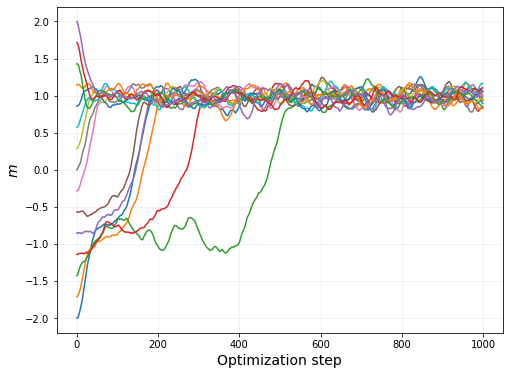

In [41]:
plot_training(sgd_momentum)

# Root mean squared propagation (RMSprop)

When the gradient of the cost function becomes too small, the training of a model can stall, leading to the so-called "vanishing gradient" problem. Root mean squared propagation, or RMSprop, is an adaptive learning rate method that aims to mitigate this issue. RMSprop is especially valuable when the model exhibits varying sensitivity to changes in different parameters, as the learning rate is scaled independently for each parameter. In our simple example, which has just one free parameter, we might not observe substantial advantages. However, these benefits become more pronounced when we consider training a complex model like a deep neural network.

Similar to momentum, RMSprop relies on storing a running average of the element-wise squared gradients (also called the second moment). Here's the algorithm:

1. Initialize the parameters $\mathbf{p}^{(0)}$ and initialize the squared gradients to zero $\mathbf{v}^{(0)} = 0$.
2. For each iteration $t > 0$, update the squared gradients and parameters as
\begin{align}
\mathbf{v}^{(t)} &= \alpha \mathbf{v}^{(t-1)} + (1-\alpha) \big( \nabla_\mathbf{p}C(\mathbf{p}^{(t-1)}) \big)^2,\\
\mathbf{p}^{(t)} &= \mathbf{p}^{(t-1)} - \frac{\eta}{\sqrt{\mathbf{v}^{(t)}} + \varepsilon} \nabla_\mathbf{p}C(\mathbf{p}^{(t-1)}),
\end{align}
where $\alpha$ is usually around 0.9, but can be anywhere in the range $[0.5, 0.999]$ and a small $\varepsilon > 0$ prevents instabilities due to division by small numbers.
3. Stop updating the parameters after a fixed number of optimization steps, or after changes in the cost function drops below some tolerance level. 

**<font color='blue'>Exercise:</font>** Write a function for the RMSprop algorithm. 

In [48]:
def rmsprop(p0=np.random.uniform(-1, 1), eta=0.01, nopt=1000, noise=0.5, alpha=0.9, epsilon=1e-8):
    
    # initialize arrays for free parameter, gradient of cost, and second moment
    p = np.zeros(nopt) 
    g = np.zeros(nopt)
    v = np.zeros(nopt)
    
    # set the initial free parameter and gradient
    p[0] = p0
    g[0] = gradient(p0, noise=noise)
    
    for t in range(1, nopt):
        
        # update the second moment
        v[t] = alpha * v[t-1] + (1-alpha) * g[t-1]**2
        
        # update the parameter 
        p[t] = p[t-1] - eta * g[t-1] / (np.sqrt(v[t]) + epsilon)
        
        # compute the gradient at new parameter
        g[t] = gradient(p[t], noise=noise)
        
    return p

**<font color='blue'>Required exercise:</font>** Plot the training curves for RMSprop. Do you notice a difference in the shape of the training curves compared to the other methods?

   Initial                Final
  -2.00000              1.11104
  -1.71429              0.93810
  -1.42857              0.96312
  -1.14286              1.03208
  -0.85714              1.04077
  -0.57143              0.93597
  -0.28571              1.01684
   0.00000              1.08371
   0.28571              0.95384
   0.57143              0.91099
   0.85714              0.92528
   1.14286              0.85788
   1.42857              1.08070
   1.71429              0.88575
   2.00000              0.89434


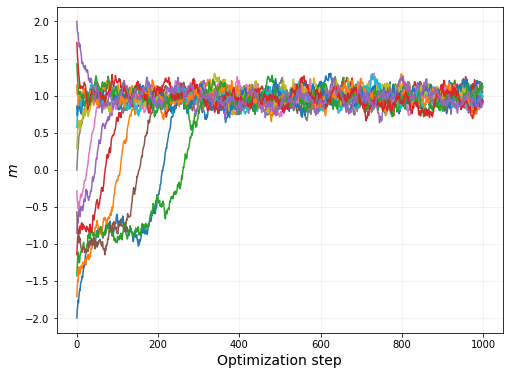

In [58]:
plot_training(rmsprop, eta=0.04)

## Adaptive moment estimation (Adam)

Adam is an optimization scheme that combines the ideas of momentum and RMSprop. It is, by far, the most popular first-order optimization method due to its efficiency and ease of implementation. The algorithm is very similar to the previous two methods, except for a bias correction term in the parameter updates:

1. Initialize the parameters $\mathbf{p}^{(0)}$, and initialize the first and second moments to zero $\mathbf{m}^{(0)} = 0$, $\mathbf{v}^{(0)} = 0$.
2. For each iteration $t > 0$, update the squared gradients and parameters as
\begin{align}
\mathbf{m}^{(t)} &= \alpha_1 \mathbf{m}^{(t-1)} + (1-\alpha_1) \nabla_\mathbf{p}C(\mathbf{p}^{(t-1)}),\\
\mathbf{v}^{(t)} &= \alpha_2 \mathbf{v}^{(t-1)} + (1-\alpha_2) \big( \nabla_\mathbf{p}C(\mathbf{p}^{(t-1)}) \big)^2,\\
\mathbf{p}^{(t)} &= \mathbf{p}^{(t-1)} - \frac{\eta}{\sqrt{\mathbf{v}^{(t)}} + \varepsilon} \left(\frac{1-\alpha_2^t}{1-\alpha_1^t} \right) \mathbf{m}^{(t)},
\end{align}
where $\alpha_1\in [0.9, 0.999]$ and $\alpha_2\in [0.9, 0.999]$ are typically good values.
3. Stop updating the parameters after a fixed number of optimization steps, or after changes in the cost function drops below some tolerance level. 

**<font color='blue'>Exercise:</font>** Write a function for the Adam algorithm. 

In [66]:
def adam(p0=np.random.uniform(-1, 1), eta=0.001, nopt=1000, noise=0.5, alpha1=0.9, alpha2=0.999, epsilon=1e-8):
    
    # initialize arrays for free parameter, gradient of cost, and moments
    p = np.zeros(nopt) 
    g = np.zeros(nopt)
    m = np.zeros(nopt)
    v = np.zeros(nopt)
    
    # set the initial free parameter and gradient
    p[0] = p0
    g[0] = gradient(p0, noise=noise)
    
    for t in range(1, nopt):
        
        # update the first moment
        m[t] = alpha1 * m[t-1] + (1-alpha1) * g[t-1]
        
        # update the second moment
        v[t] = alpha2 * v[t-1] + (1-alpha2) * g[t-1]**2
        
        # update the parameter 
        bias = (1 - alpha2**t) / (1 - alpha1**t)
        p[t] = p[t-1] - eta * bias * m[t] / (np.sqrt(v[t]) + epsilon)
        
        # compute the gradient at new parameter
        g[t] = gradient(p[t], noise=noise)
        
    return p

**<font color='blue'>Required exercise:</font>** Plot how the magnetization evolves during training. Play with the parameters $\alpha_1$ and $\alpha_2$. How does the shape of Adam's training curves compare to the previous methods?

   Initial                Final
  -2.00000              0.88597
  -1.71429              1.04322
  -1.42857              1.11564
  -1.14286              1.00566
  -0.85714              1.12635
  -0.57143              0.87992
  -0.28571              0.98471
   0.00000              1.03221
   0.28571              0.94414
   0.57143              1.00229
   0.85714              0.94126
   1.14286              1.07116
   1.42857              1.04339
   1.71429              1.04242
   2.00000              1.00941


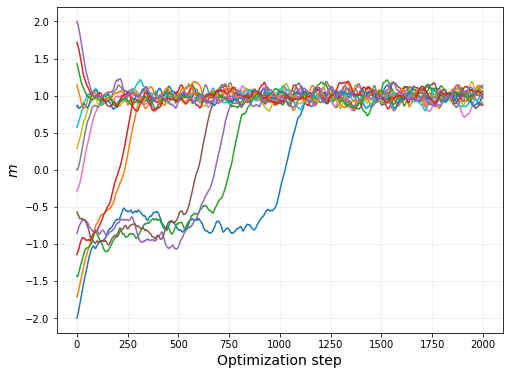

In [83]:
plot_training(adam, eta=0.02, alpha1=0.9, alpha2=0.9, nopt=2000)

## Congratulations! 

You have successfully explored various gradient descent methods while navigating a challenging local minimum.